In [3]:
import os

import xarray as xr
import numpy as np
import torch
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

import matplotlib
import matplotlib.pyplot as plt

import copy
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

import cartopy.crs as ccrs
from datetime import datetime

In [4]:
from WD.regridding import regrid_to_res

In [5]:
ds_id = "590781"
model_id = "495CD7"

In [6]:
predictions_experiments = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")
targets_experiments = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")

In [7]:
rmse = compute_weighted_rmse(predictions_experiments.isel({"ensemble_member":0}), targets_experiments.isel({"ensemble_member":0}))
print("{}, RMSE_z is {:.1f}".format(model_id, rmse.z_500.values))

495CD7, RMSE_z is 1689.5


In [8]:
interpolated_predictions = regrid_to_res(predictions_experiments, "5.625deg", reuse_weights=False)

interpolated_targets = regrid_to_res(targets_experiments, "5.625deg", reuse_weights=False)

In [9]:
# careful: here we neglect the lead_time between forecast initialization and the actual forecast! This will cause a shift in time
ds_low_res = xr.open_mfdataset("/data/compoundx/WeatherBench/geopotential_500/*.nc").sel(time=targets_experiments.init_time.values)  

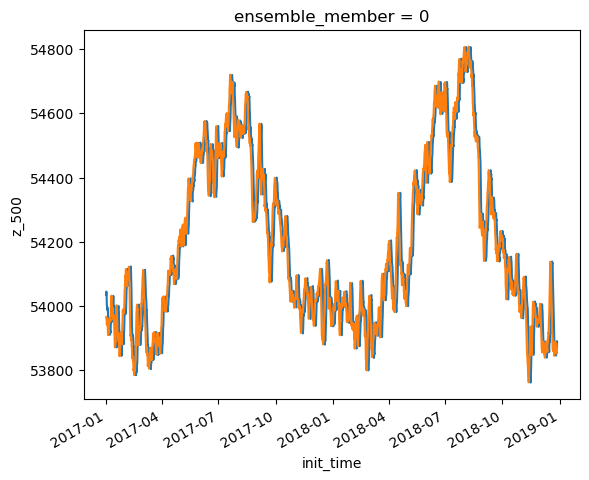

In [10]:
ds_low_res.mean(("lat", "lon")).z.plot()

interpolated_targets.mean(("lat", "lon", "lead_time")).z_500.plot()

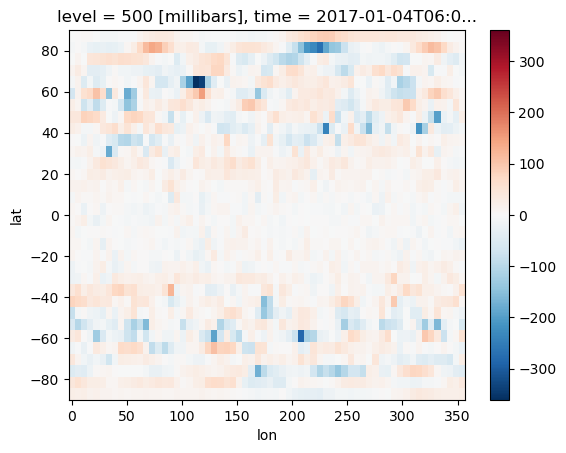

In [11]:
(ds_low_res.isel({"time":12}).z - interpolated_targets.isel({"init_time":0}).z_500).plot()

The interpolated high resolution ground truth is not exactly identical to the low resolution ground truth.

In [17]:
rmse_low_res = compute_weighted_rmse(interpolated_predictions.isel({"ensemble_member":0}), interpolated_targets.isel({"ensemble_member":0}))
print("{}, RMSE_z low resis {:.1f}".format(model_id, rmse_low_res.z_500.values))

495CD7, RMSE_z low resis 1680.3


In [18]:
interpolated_predictions

<xarray.Dataset>
Dimensions:          (ensemble_member: 1, init_time: 2904, lead_time: 1,
                      lat: 32, lon: 64)
Coordinates:
  * init_time        (init_time) datetime64[ns] 2017-01-01T06:00:00 ... 2018-...
  * lead_time        (lead_time) int64 12
  * ensemble_member  (ensemble_member) int64 0
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z_500            (ensemble_member, init_time, lead_time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear